# Mg II Parameter Grid

In [1]:
import os.path
import sys
homelibs = os.path.expanduser("~")
muramlibs = os.path.expanduser("~/muram/python_codes")
hanlertlibs = os.path.expanduser("~/hanlert/python")
sys.path.extend([homelibs,muramlibs,hanlertlibs])

In [21]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.signal
import hanlert.plot
import muram2hanlert.jobs

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams.update({'font.size': 12})

In [7]:
jobpath = "/glade/p/hao/radmhd/egeland/MgII_uniformB"

In [9]:
!ls $jobpath | head
print("...")
!ls $jobpath | tail

B_0000
B_0001
B_0002
B_0003
B_0004
B_0005
B_0006
B_0007
B_0008
B_0009
ls: write error: Broken pipe
...
B_2591
B_2592
B_2593
B_2594
B_2595
B_2596
B_2597
B_2598
B_2599
uniformB.npy


In [11]:
B = np.load(os.path.join(jobpath, "uniformB.npy"))

## Computational Cost

median runtime: 9.333 minutes


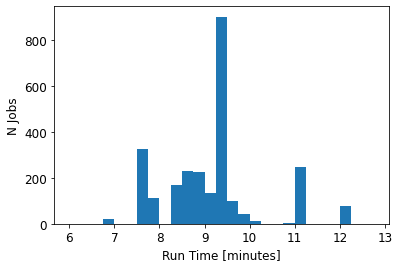

In [12]:
# Get the last line of each output file which contains the computation time
! find $jobpath -name stdout | xargs -n1 tail -n1 > MgII_uniformB_time
def calc_cost():
    timefile = open("MgII_uniformB_time")
    runtimes = []
    for timeline in timefile:
        t = muram2hanlert.jobs.parse_time(timeline)
        runtimes.append(t)
    runtimes = np.array(runtimes) / 60. # minutes
    print(f"median runtime: {np.median(runtimes):0.3f} minutes")
    
    bins = np.arange(6, 13, 0.25) # 1/4 min (15 sec) bin resolution
    fig, ax = plt.subplots()
    ax.hist(runtimes, bins=bins)
    ax.set_xlabel("Run Time [minutes]")
    ax.set_ylabel("N Jobs")
    fig.savefig("MgII_uniformB_time.png")
calc_cost()

In [13]:
BANGLE = 30
sel = B[:, 1] == BANGLE
selixs = np.where(sel)[0]
print("Number of B vectors selected:", sel.sum(), len(selixs))

Number of B vectors selected: 200 200


In [14]:
def ordered_extrema(x):
    """Returns min/max extrema indices ordered from least/greatest ascending/descending"""
    ix_mins = scipy.signal.argrelmin(x)[0]
    ix_maxs = scipy.signal.argrelmax(x)[0]
    order_mins = np.argsort(x[ix_mins])
    order_maxs = np.argsort(x[ix_maxs])[::-1]
    return ix_mins[order_mins], ix_maxs[order_maxs]

def profile_extrema_old(x, ix_center=None):
    if ix_center is None:
        ix_center = int(np.floor((x.size - 1)/2))
    center = x[ix_center]    
    order_mins, order_maxs = ordered_extrema(x)

    amp_mins = center - x[order_mins]
    amp_maxs = x[order_maxs] - center
    sum_2mins = np.sum(amp_mins[0:2])
    sum_2maxs = np.sum(amp_maxs[0:2])
    amp_tot = x[order_maxs[0]] - x[order_mins[0]]
    bot_min = order_mins[0]
    top_max = order_maxs[0]
                 
    if amp_tot > sum_2mins and amp_tot > sum_2maxs:
        ix_min = bot_min
        ix_max = top_max
    elif sum_2mins > sum_2maxs:
        ix_min = bot_min
        ix_max = ix_center
    elif sum_2mins < sum_2maxs:
        ix_min = ix_center
        ix_max = top_max

    return ix_min, ix_max

def profile_extrema(x, ix_center=None, dist_thresh=5):
    # TODO: remove dist_thresh hack that prevents extrema very near center from being selected
    #       use amplitude, e.g. "biggest thing to left and biggest thing to right"
    if ix_center is None:
        ix_center = int(np.floor((x.size - 1)/2))
    center = x[ix_center]    
    order_mins, order_maxs = ordered_extrema(x)
    all_extrema = np.append(order_mins, order_maxs)
    dist = all_extrema - ix_center
    
    left = dist < -dist_thresh
    right = dist > +dist_thresh
    first_left = all_extrema[left][np.argmin(np.abs(dist[left]))]
    first_right = all_extrema[right][np.argmin(np.abs(dist[right]))]
    left_right = [first_left, first_right]
    ix_min = left_right[np.argmin(x[left_right])]
    ix_max = left_right[np.argmax(x[left_right])]
    themin = x[ix_min]
    themax = x[ix_max]

    if center < themin and center < themax:
        ix_min = ix_center
    elif center > themin and center > themax:
        ix_max = ix_center

    return ix_min, ix_max

k region ixs: 314 350 371 393 428
k region L: 279.5834939259173 279.6204990626851 279.63517676298795 279.64985600428076 279.6868787114122
h region ixs: 761 794 814 833 867
h region L: 280.31303564100995 280.3395776465627 280.3530542082255 280.3664036398547 280.3930842034818
hk center ix: 592
hk center L: 279.8803651034194


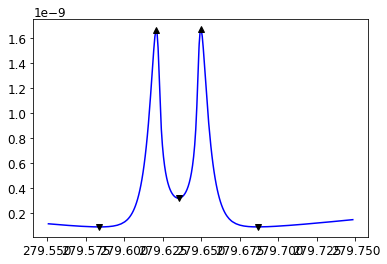

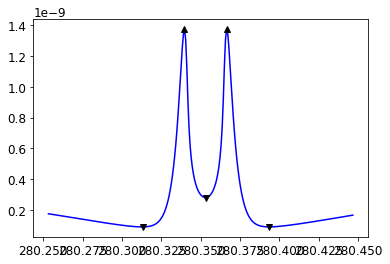

In [15]:
def build_regions(stokes, Lmin, Lmax):
    L = stokes['L']
    I = stokes['I']
    sel = (L > Lmin) & (L < Lmax)
    
    fig, ax = plt.subplots()
    ax.plot(L[sel], I[sel], 'b-')
    
    ix_sel_min = np.where(sel)[0][0]
    ix_mins, ix_maxs = ordered_extrema(I[sel])
    ix_mins += ix_sel_min
    ix_maxs += ix_sel_min
    ax.plot(L[ix_mins], I[ix_mins], 'kv')
    ax.plot(L[ix_maxs], I[ix_maxs], 'k^')
    return sorted(ix_mins), sorted(ix_maxs)

    
stokesfile = os.path.join(jobpath, "B_0000", "Stokes_1_1")
stokes = hanlert.read_stokes(stokesfile)
L = stokes['L']

ix_mins, ix_maxs = build_regions(stokes, 279.55, 279.75)
ix_k3v, ix_k, ix_k3r = ix_mins
L_k3v, L_k, L_k3r = L[ix_mins]
ix_k2v, ix_k2r = ix_maxs
L_k2v, L_k2r = L[ix_maxs]
print("k region ixs:", ix_k3v, ix_k2v, ix_k, ix_k2r, ix_k3r)
print("k region L:", L_k3v, L_k2v, L_k, L_k2r, L_k3r)

ix_mins, ix_maxs = build_regions(stokes, 280.25, 280.45)
ix_h3v, ix_h, ix_h3r = ix_mins
L_h3v, L_h, L_h3r = L[ix_mins]
ix_h2v, ix_h2r = ix_maxs
L_h2v, L_h2r = L[ix_maxs]
print("h region ixs:", ix_h3v, ix_h2v, ix_h, ix_h2r, ix_h3r)
print("h region L:", L_h3v, L_h2v, L_h, L_h2r, L_h3r)

ix_hk = int( (ix_k + ix_h)/2 )
L_hk = L[ix_hk]
print("hk center ix:", ix_hk)
print("hk center L:", L_hk)

def sel_region(L, region):
    if region == 'all':
        sel = (L > 250) # all Mg II wings
    elif region == 'hk':
        dL = 1.; sel = (L > (L_hk - dL/2) ) & (L < (L_hk + dL/2)) # both cores; 1 nm
    elif region == 'k':
        dL = 0.2; sel = (L > (L_k - dL/2)) & (L < (L_k + dL/2)) # Mg II k; 0.2 nm
    elif region == 'k3':
        sel = (L > L_k3v) & (L < L_k3r)
    elif region == 'h':
        dL = 0.2; sel = (L > (L_h - dL/2)) & (L < (L_h + dL/2)) # Mg II h; 0.2 nm
    elif region == 'h3':
        sel = (L > L_h3v) & (L < L_h3r)
    return sel

sel_region(L, 'hk');

R_hi: 400103.649


Text(0, 0.5, 'R = L / dL')

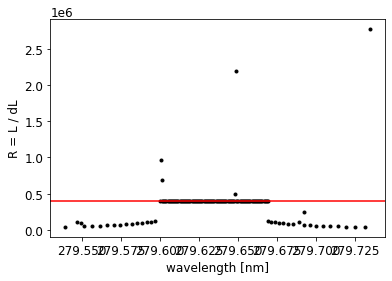

In [22]:
# Plot the spectral resolution
def calc_R(L, region='all'):
    dL = L[1:] - L[0:-1]
    Lmid = L[0:-1] - (dL/2)
    R = Lmid / dL
    sel = sel_region(Lmid, region)
    return Lmid[sel], R[sel]

Lmid, R = calc_R(L, 'k')
R_hi = np.percentile(R, 90)
print(f"R_hi: {R_hi:0.3f}")
    
fig, ax = plt.subplots()
ax.plot(Lmid, R, 'k.')
ax.axhline(R_hi, c='r')
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('R = L / dL')

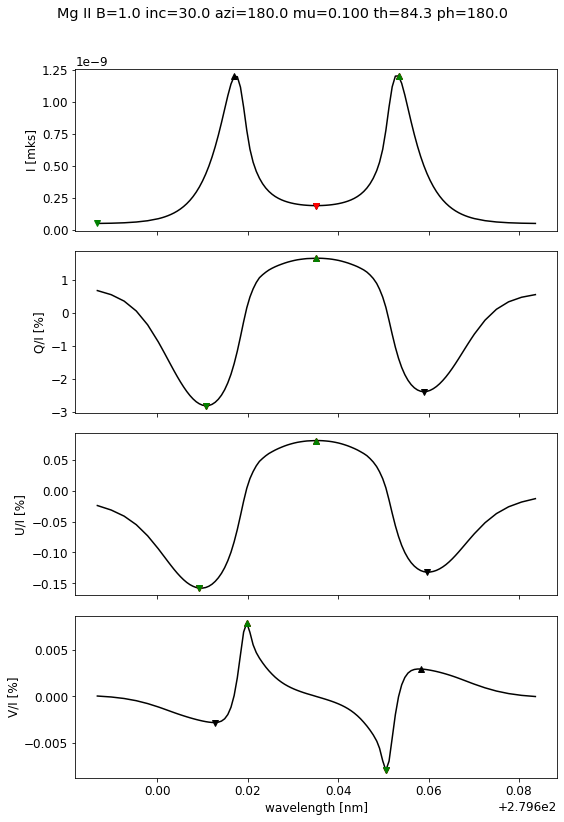

In [23]:
def plot_MgII(ix=50, imu=1, iph=2, region='hk', Bmax=200., values='relative', fig=None, cmap='copper', mark_extrema=False):
    jobdir = f"B_{ix:04d}"
    stokesfile = os.path.join(jobpath, jobdir, f"Stokes_{imu}_{iph}")
    stokes = hanlert.read_stokes(stokesfile)
    mu = stokes['mu']
    th = stokes['th']
    ph = stokes['ph']
    Bi = B[ix]
    Bmag = Bi[0]
    Binc = Bi[1]
    Bazi = Bi[2]
    
    sel = sel_region(stokes['L'], region)
    
    cmap = mpl.cm.get_cmap(cmap)
    if fig is None:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8,12), sharex=True)
    else:
        (ax1, ax2, ax3, ax4) = fig.axes
    
    if values == 'relative':
        axes = (('I', ax1), ('Q/I', ax2), ('U/I', ax3), ('V/I', ax4))
        unit = ' [%]'
    elif values == 'absolute':
        axes = (('I', ax1), ('Q', ax2), ('U', ax3), ('V', ax4))
        unit = ' [mks]'

    for s, ax in axes:
        ax.plot(stokes['L'][sel], stokes[s][sel], '-', c=cmap(Bmag/Bmax))
        if mark_extrema:
            ix_mins, ix_maxs = ordered_extrema(stokes[s][sel])
            ax.plot(stokes['L'][sel][ix_maxs], stokes[s][sel][ix_maxs], 'k^')
            ax.plot(stokes['L'][sel][ix_mins], stokes[s][sel][ix_mins], 'kv')
            
            prof_min, prof_max = profile_extrema(stokes[s][sel])
            ax.plot(stokes['L'][sel][prof_max], stokes[s][sel][prof_max], 'r^')
            ax.plot(stokes['L'][sel][prof_min], stokes[s][sel][prof_min], 'rv')
            
            band_min = np.argmin(stokes[s][sel])
            band_max = np.argmax(stokes[s][sel])
            ax.plot(stokes['L'][sel][band_max], stokes[s][sel][band_max], 'g^')
            ax.plot(stokes['L'][sel][band_min], stokes[s][sel][band_min], 'gv')
        ax.set_ylabel(s + unit)
    if values == 'relative':
        ax1.set_ylabel('I [mks]') # label fixed here
    ax4.set_xlabel('wavelength [nm]')
    fig.suptitle(f'Mg II B={Bmag:0.1f} inc={Binc:0.1f} azi={Bazi:0.1f} mu={mu:0.3f} th={th:0.1f} ph={ph:0.1f}')
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    return fig

region = 'k3'
imu = 7
iph = 13
values = 'relative'
fig = plot_MgII(selixs[0], imu=imu, iph=iph, region=region, values=values, mark_extrema=True)
#for ix in selixs:
#    plot_MgII(ix, imu=imu, iph=iph, region=region, values=values, mark_extrema=True, fig=fig)

# TODO: instead of trying to define the amplitude in terms of extrema for every profile,
# simply define the minima and maxima within the "core" defined by the minima on either side 
# of the reversals in I


#plot_MgII(49, region=region, values=values, fig=fig);

XXX rms=4.43861e-10 rms_fft=4.43861e-10
XXX rms=1.46571e+00 rms_fft=1.46571e+00
XXX rms=8.50215e-02 rms_fft=8.50215e-02
XXX rms=2.44448e-03 rms_fft=2.44448e-03
XXX rms=4.43857e-10 rms_fft=4.43857e-10
XXX rms=1.37499e+00 rms_fft=1.37499e+00
XXX rms=3.94047e-01 rms_fft=3.94047e-01
XXX rms=1.22191e-02 rms_fft=1.22191e-02
XXX rms=4.43897e-10 rms_fft=4.43897e-10
XXX rms=1.16922e+00 rms_fft=1.16922e+00
XXX rms=6.43326e-01 rms_fft=6.43326e-01
XXX rms=2.44208e-02 rms_fft=2.44208e-02
XXX rms=4.43897e-10 rms_fft=4.43897e-10
XXX rms=9.66133e-01 rms_fft=9.66133e-01
XXX rms=7.39710e-01 rms_fft=7.39710e-01
XXX rms=3.66025e-02 rms_fft=3.66025e-02
XXX rms=4.43898e-10 rms_fft=4.43898e-10
XXX rms=8.09188e-01 rms_fft=8.09188e-01
XXX rms=7.43496e-01 rms_fft=7.43496e-01
XXX rms=4.87724e-02 rms_fft=4.87724e-02
XXX rms=4.43897e-10 rms_fft=4.43897e-10
XXX rms=6.95471e-01 rms_fft=6.95471e-01
XXX rms=7.06955e-01 rms_fft=7.06955e-01
XXX rms=6.09360e-02 rms_fft=6.09360e-02
XXX rms=4.43894e-10 rms_fft=4.43894e-10


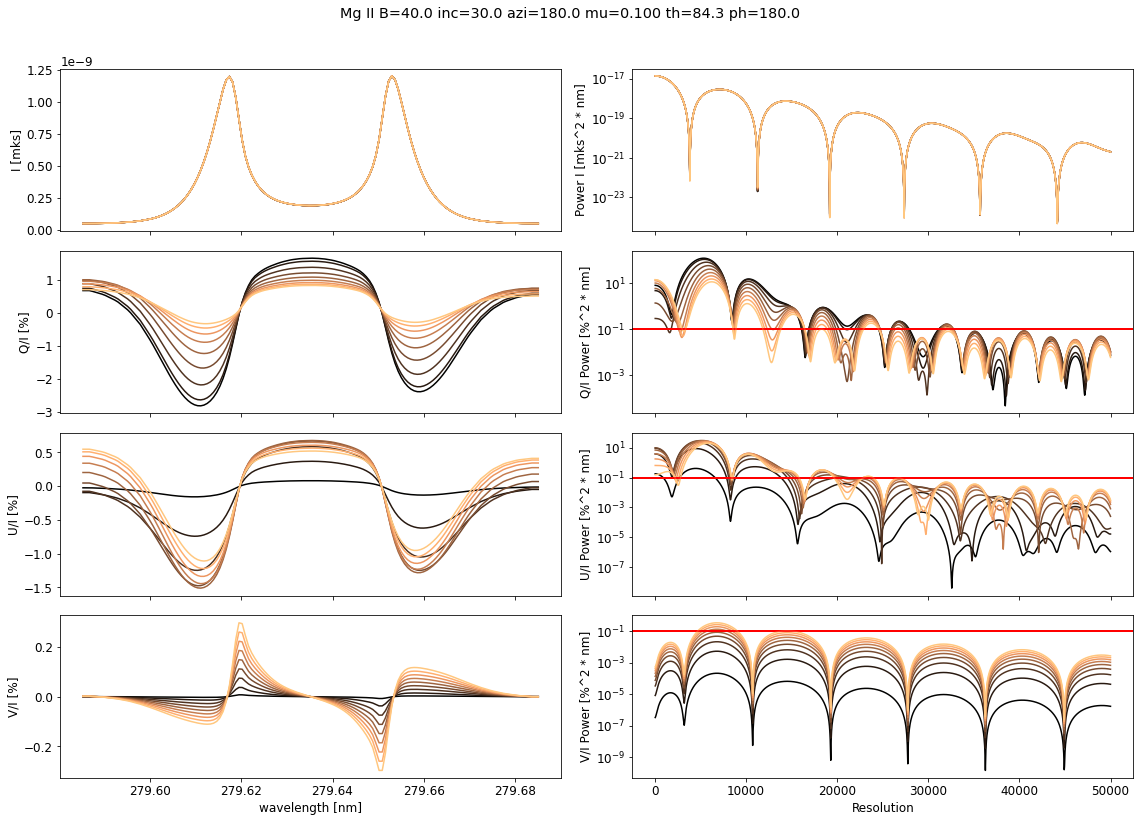

In [24]:
def freqvals(t):
    """Return (N, period, interval, nyquist freq, low frequency) from time axis"""
    N = len(t)
    T = t[-1] - t[0]
    dt = T/N
    nyquist = 1/(2.0*dt)
    lowfreq = 1/T
    return (N, T, dt, nyquist, lowfreq)

def oversample_NFreq(t, oversample):
    """Compute number of frequencies to use when oversampling a FFT"""
    (N, T, dt, nyquist, lowfreq) = freqvals(t)
    return 2 * int((nyquist - lowfreq) / ( lowfreq / oversample) + 1) + 1

def plot_MgII_fft(ix=50, imu=1, iph=2, region='hk', Bmax=200., values='relative', oversample=100, fig=None, cmap='copper'):
    jobdir = f"B_{ix:04d}"
    stokesfile = os.path.join(jobpath, jobdir, f"Stokes_{imu}_{iph}")
    stokes = hanlert.read_stokes(stokesfile)
    mu = stokes['mu']
    th = stokes['th']
    ph = stokes['ph']
    Bi = B[ix]
    Bmag = Bi[0]
    Binc = Bi[1]
    Bazi = Bi[2]
    
    sel = sel_region(stokes['L'], region)
    
    # Create a high-resolution uniform grid
    Lmid, R = calc_R(stokes['L'], region)
    R_hi = np.percentile(R, 90)
    dL = np.min(Lmid) / R_hi
    L_uni = np.arange(np.min(Lmid), np.max(Lmid) + dL, dL)
    (N, X, dL, nyquist, lowfreq) = freqvals(L_uni)
    Nfreq = oversample_NFreq(L_uni, oversample)
    
    cmap = mpl.cm.get_cmap(cmap)
    if fig is None:
        fig, ((ax1a, ax1b), (ax2a, ax2b), (ax3a, ax3b), (ax4a, ax4b)) = plt.subplots(4, 2, figsize=(16,12), sharex='col')
    else:
        (ax1a, ax1b, ax2a, ax2b, ax3a, ax3b, ax4a, ax4b) = fig.axes
    
    if values == 'relative':
        axes = (('I', ax1a, ax1b), ('Q/I', ax2a, ax2b), ('U/I', ax3a, ax3b), ('V/I', ax4a, ax4b))
        unitA = ' [%]'
        unitB = ' Power [%^2 * nm]'
    elif values == 'absolute':
        axes = (('I', ax1a, ax1b), ('Q', ax2a, ax2b), ('U', ax3a, ax3b), ('V', ax4a, ax4b))
        unitA = ' [mks]'
        unitB = ' Power [mks^2 * nm]'

    np.seterr(divide = 'ignore') 
    for s, axA, axB in axes:
        stokes_uni = np.interp(L_uni, stokes['L'][sel], stokes[s][sel])
        axA.plot(L_uni, stokes_uni, '-', c=cmap(Bmag/Bmax))
        axA.set_ylabel(s + unitA)

        N = stokes_uni.size
        ps = np.abs(np.fft.fft(stokes_uni, n=Nfreq))**2/N
        amp = np.sqrt(ps)
        k = np.fft.fftfreq(Nfreq, dL)
        l = 1/k
        R = np.median(L_uni)/l
        hipass = k >= lowfreq
        pos = k > 0
        #sel2 = pos & hipass # selection based on l
        sel2 = pos & (R < 50000)
        #ax.plot(L_uni, stokes_uni, '-', c=cmap(Bmag/Bmax))
        
        # check Parseval's theorem
        rms = np.sqrt(np.mean(np.power(stokes_uni, 2)))
        rms_fft = np.sqrt(np.mean(ps)) # XXX the above requires oversample
        print(f"XXX rms={rms:0.5e} rms_fft={rms_fft:0.5e}")
        
        axB.plot(R[sel2], ps[sel2], '-', c=cmap(Bmag/Bmax))
        if s[0] != 'I':
            axB.axhline(0.1, c='r')
        axB.set_yscale('log')
        axB.set_ylabel(s + unitB)
    if values == 'relative':
        ax1a.set_ylabel('I [mks]')
        ax1b.set_ylabel('Power I [mks^2 * nm]') # label fixed here
    ax4a.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useOffset=False))
    ax4a.set_xlabel('wavelength [nm]')
    #ax4b.set_xlabel('wavelength scale [nm]')
    ax4b.set_xlabel('Resolution')
    fig.suptitle(f'Mg II B={Bmag:0.1f} inc={Binc:0.1f} azi={Bazi:0.1f} mu={mu:0.3f} th={th:0.1f} ph={ph:0.1f}')
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    return fig

region = 'k3'
imu = 7
iph = 13 # 1 = 0 deg; 13 = 180 deg
values = 'relative'
fig = plot_MgII_fft(selixs[0], imu=imu, iph=iph, region=region, values=values)
for ix in selixs[4:40:5]:
    plot_MgII_fft(ix, imu=imu, iph=iph, region=region, values=values, fig=fig, Bmax=40)
fig.savefig('example_fft_MgII_k_power_B1to40.png')

In [25]:
# Plot stack plots for every region and LOS
# Note: this is slow
for region in ('hk', 'h', 'k'):
    for iph in (1, 13):
        for imu in range(1, 8, 1):
            print(f"plotting region={region} imu={imu} iph={iph})")
            fig = None
            for ix in selixs:
                fig = plot_MgII(ix, region=region, imu=imu, iph=iph, fig=fig)
                fig.show()
            fig.savefig(f'MgII_stack_{region}_{imu}_{iph}.png')
            plt.close(fig)

plotting region=hk imu=1 iph=1)
plotting region=hk imu=2 iph=1)
plotting region=hk imu=3 iph=1)
plotting region=hk imu=4 iph=1)
plotting region=hk imu=5 iph=1)
plotting region=hk imu=6 iph=1)
plotting region=hk imu=7 iph=1)
plotting region=hk imu=1 iph=13)
plotting region=hk imu=2 iph=13)
plotting region=hk imu=3 iph=13)
plotting region=hk imu=4 iph=13)
plotting region=hk imu=5 iph=13)
plotting region=hk imu=6 iph=13)
plotting region=hk imu=7 iph=13)
plotting region=h imu=1 iph=1)
plotting region=h imu=2 iph=1)
plotting region=h imu=3 iph=1)
plotting region=h imu=4 iph=1)
plotting region=h imu=5 iph=1)
plotting region=h imu=6 iph=1)
plotting region=h imu=7 iph=1)
plotting region=h imu=1 iph=13)
plotting region=h imu=2 iph=13)
plotting region=h imu=3 iph=13)
plotting region=h imu=4 iph=13)
plotting region=h imu=5 iph=13)
plotting region=h imu=6 iph=13)
plotting region=h imu=7 iph=13)
plotting region=k imu=1 iph=1)
plotting region=k imu=2 iph=1)
plotting region=k imu=3 iph=1)
plotting re

In [26]:
def LOS_mapping(jobpath, jobdir):
    mus = []
    phs = []
    for f in sorted(os.listdir(os.path.join(jobpath, jobdir))):
        if not f.startswith('Stokes_'):
            continue
        stokesfile = os.path.join(jobpath, jobdir, f)
        prefix, imu, iph = f.split('_')
        imu = int(imu)
        iph = int(iph)
        mus.append(imu)
        phs.append(iph)
        
    # Open files and build array of mu, th, ph values
    # Note: indices imu, iph counts from 1; therefore 0 => None
    mu_vals = [None]
    th_vals = [None]
    for imu in sorted(set(mus)):
        stokesfile = os.path.join(jobpath, jobdir, f"Stokes_{imu}_1")
        stokes = hanlert.read_stokes(stokesfile)
        mu_vals.append(stokes['mu'])
        th_vals.append(stokes['th'])
    ph_vals = [None]
    for iph in sorted(set(phs)):
        stokesfile = os.path.join(jobpath, jobdir, f"Stokes_1_{iph}")
        stokes = hanlert.read_stokes(stokesfile)
        ph_vals.append(stokes['ph'])
        
    return mu_vals, th_vals, ph_vals
        
mu_vals, th_vals, ph_vals = LOS_mapping(jobpath, "B_0000")
print("mu:", mu_vals)
print("th:", th_vals)
print("ph:", ph_vals)

mu: [None, 1.0, 0.9659258262890683, 0.8660254037844387, 0.7071067811865476, 0.4999999999999999, 0.2588190451025205, 0.1]
th: [None, 0.0, 14.999999999999996, 29.999999999999993, 45.0, 60.00000000000001, 75.00000000000001, 84.26082952273322]
ph: [None, 0.0, 14.999999999999998, 29.999999999999996, 45.0, 59.99999999999999, 75.00000000000001, 90.0, 105.0, 119.99999999999999, 135.0, 150.00000000000003, 164.99999999999997, 180.0]


In [27]:
def find_extrema(ix=50, imu=1, iph=1, region='hk'):
    call_str = f"ix={ix} imu={imu} iph={iph} region={region}"
    jobdir = f"B_{ix:04d}"
    stokesfile = os.path.join(jobpath, jobdir, f"Stokes_{imu}_{iph}")
    stokes = hanlert.read_stokes(stokesfile)
    
    mu = stokes['mu']
    th = stokes['th']
    ph = stokes['ph']
    Bmax = np.max(B[:,0])
    Bi = B[ix]
    Bmag = Bi[0]
    Binc = Bi[1]
    Bazi = Bi[2]
    
    sel = sel_region(stokes['L'], region)
    
    ix_sel_min = np.where(sel)[0][0]
    ix_sel_max = np.where(sel)[0][-1]
    
    result = dict(imu=imu, mu=mu, th=th, iph=iph, ph=ph, Bmag=Bmag, Binc=Binc, Bazi=Bazi, region=region)
    for s in ('I', 'Q', 'U', 'V', 'Q/I', 'U/I', 'V/I'):
        ix_min = np.argmin(stokes[s][sel]) + ix_sel_min
        ix_max = np.argmax(stokes[s][sel]) + ix_sel_min
        s_min = stokes[s][ix_min]
        s_max = stokes[s][ix_max]
        s_amp = s_max - s_min
        result[s] = {'ix_min':ix_min, 'ix_max':ix_max, 'min':s_min, 'max':s_max, 'amp':s_amp}
        
    return result

find_extrema(1)

{'imu': 1,
 'mu': 1.0,
 'th': 0.0,
 'iph': 1,
 'ph': 0.0,
 'Bmag': 2.0,
 'Binc': 0.0,
 'Bazi': 180.0,
 'region': 'hk',
 'I': {'ix_min': 604,
  'ix_max': 393,
  'min': 5.460623619397704e-11,
  'max': 1.6727781997905257e-09,
  'amp': 1.6181719635965487e-09},
 'Q': {'ix_min': 337,
  'ix_max': 772,
  'min': -4.196382508563897e-26,
  'max': 3.361966635658021e-27,
  'amp': 4.532579172129699e-26},
 'U': {'ix_min': 772,
  'ix_max': 337,
  'min': -3.674140518855641e-27,
  'max': 4.3514709523650384e-26,
  'amp': 4.7188850042506025e-26},
 'V': {'ix_min': 389,
  'ix_max': 353,
  'min': -3.0705204637079793e-13,
  'max': 3.0633224160426295e-13,
  'amp': 6.133842879750609e-13},
 'Q/I': {'ix_min': 318,
  'ix_max': 762,
  'min': -2.8952387769128356e-14,
  'max': 3.3424657152528517e-15,
  'amp': 3.2294853484381205e-14},
 'U/I': {'ix_min': 762,
  'ix_max': 317,
  'min': -3.7231469870723056e-15,
  'max': 3.076225702311845e-14,
  'amp': 3.448540401019075e-14},
 'V/I': {'ix_min': 637,
  'ix_max': 798,
  'mi

In [28]:
mins = np.zeros((2, 13, 7, len(selixs), 7)) # region, ph, mu, Bmag, stokes
maxs = np.zeros((2, 13, 7, len(selixs), 7)) # region, ph, mu, Bmag, stokes
amps = np.zeros((2, 13, 7, len(selixs), 7)) # region, ph, mu, Bmag, stokes

for region in ('h3', 'k3'):
    if region == 'h3':
        iregion = 0
    else:
        iregion = 1
    for iph in range(1, 14, 1):
        for imu in range(1, 8, 1):
            for iB2, iB in enumerate(selixs):
                extrema = find_extrema(iB, region=region, imu=imu, iph=iph)
                for iS, S in enumerate(('I', 'Q', 'U', 'V', 'Q/I', 'U/I', 'V/I')):
                    mins[iregion][iph - 1][imu - 1][iB2][iS] = extrema[S]['min']
                    maxs[iregion][iph - 1][imu - 1][iB2][iS] = extrema[S]['max']
                    amps[iregion][iph - 1][imu - 1][iB2][iS] = extrema[S]['amp']

In [29]:
dampdB = np.gradient(amps, 1, axis=3)
dabsampdB = np.abs(dampdB)

In [30]:
dampdB.shape

(2, 13, 7, 200, 7)

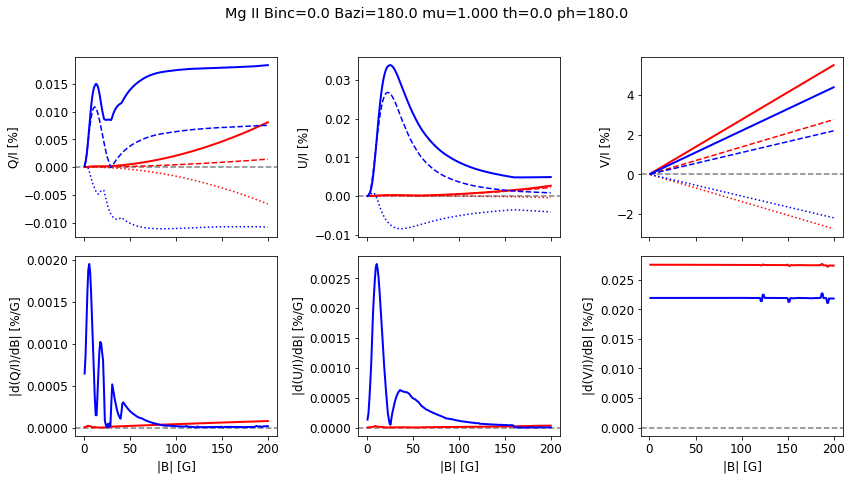

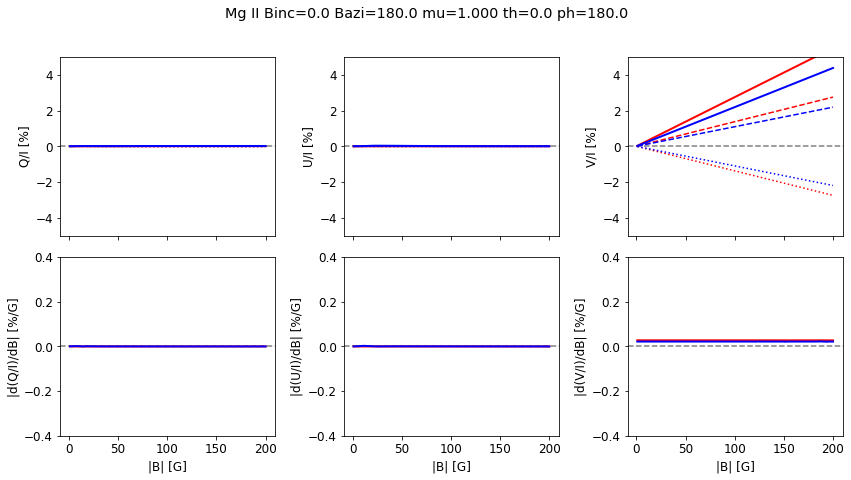

In [31]:
# good limits for relative: abslim=(-3,+3), derivlim=(-0.25,+0.25)
def plot_response(imu, iph, abslim=None, derivlim=None, values='relative', save=False):
    mu = mu_vals[imu]
    th = th_vals[imu]
    ph = ph_vals[iph]
    savefile = f'MgII_response_{imu}_{iph}.png'
    
    Bsel = B[selixs][:, 0]
    
    # In the following arrays, we count from 0
    imu = imu - 1
    iph = iph - 1
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,7), sharex=True)
    for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
        ax.axhline(c='gray', ls='--')

    region_labels = ('h', 'k')
    region_colors = ('r', 'b')
    if values == 'absolute':
        iSs = (1, 2, 3)
        Slabels = ('Q', 'U', 'V')
        unit = 'mks'
    elif values == 'relative':
        iSs = (4, 5, 6)
        Slabels = ('Q/I', 'U/I', 'V/I')
        unit = '%'
    axs = ((ax1, ax4), (ax2, ax5), (ax3, ax6))
    
    for ireg in (0, 1):
        c = region_colors[ireg]
        for i in range(3):
            iS = iSs[i]
            label = Slabels[i]
            ax_abs, ax_deriv = axs[i]
            ax_abs.plot(Bsel, maxs[ireg, iph, imu, :, iS], c=c, ls='--')
            ax_abs.plot(Bsel, mins[ireg, iph, imu, :, iS], c=c, ls=':')
            ax_abs.plot(Bsel, amps[ireg, iph, imu, :, iS], c=c, ls='-', lw=2)
            ax_abs.set_ylabel(label + f' [{unit}]')

            # calculate derivatives
            dmaxdB = np.gradient(maxs[ireg, iph, imu, :, iS], 1)
            dmindB = np.gradient(mins[ireg, iph, imu, :, iS], 1)
            dampdB = np.gradient(amps[ireg, iph, imu, :, iS], 1)
            dabsampdB = np.abs(dampdB)

            #ax_deriv.plot(B[:,0], dmaxdB, c=c, ls='--')
            #ax_deriv.plot(B[:,0], dmindB, c=c, ls=':')
            ax_deriv.plot(Bsel, dabsampdB, c=c, ls='-', lw=2)
            ax_deriv.set_ylabel(f"|d({label})/dB| [{unit}/G]")

    for ax in (ax1, ax2, ax3):
        ax.set_ylim(abslim)
    for ax in (ax4, ax5, ax6):
        ax.set_ylim(derivlim)
        ax.set_xlabel('|B| [G]')
        
    fig.suptitle("Mg II Polarization Amplitude and Response")
    fig.suptitle(f'Mg II Binc={B[0,1]:0.1f} Bazi={B[0,2]:0.1f} mu={mu:0.3f} th={th:0.1f} ph={ph:0.1f}')
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    if save:
        fig.savefig(savefile)

imu = 1
iph = 13
plot_response(imu, iph)
plot_response(imu, iph, abslim=(-5,+5), derivlim=(-0.4,+0.4))

plotting response imu=1 iph=1
plotting response imu=2 iph=1
plotting response imu=3 iph=1
plotting response imu=4 iph=1
plotting response imu=5 iph=1
plotting response imu=6 iph=1
plotting response imu=7 iph=1
plotting response imu=1 iph=13
plotting response imu=2 iph=13
plotting response imu=3 iph=13
plotting response imu=4 iph=13
plotting response imu=5 iph=13
plotting response imu=6 iph=13
plotting response imu=7 iph=13


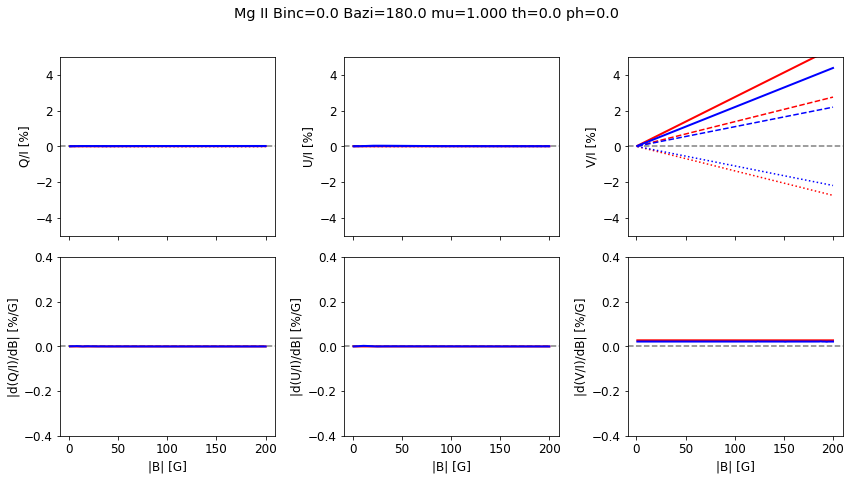

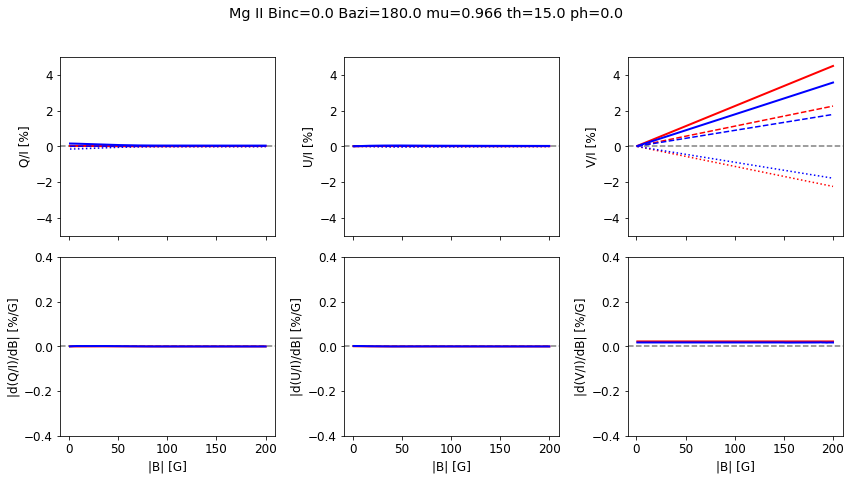

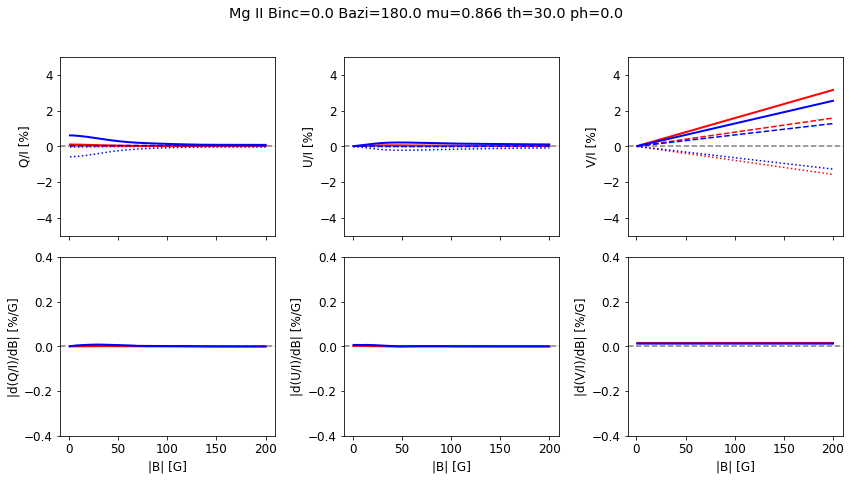

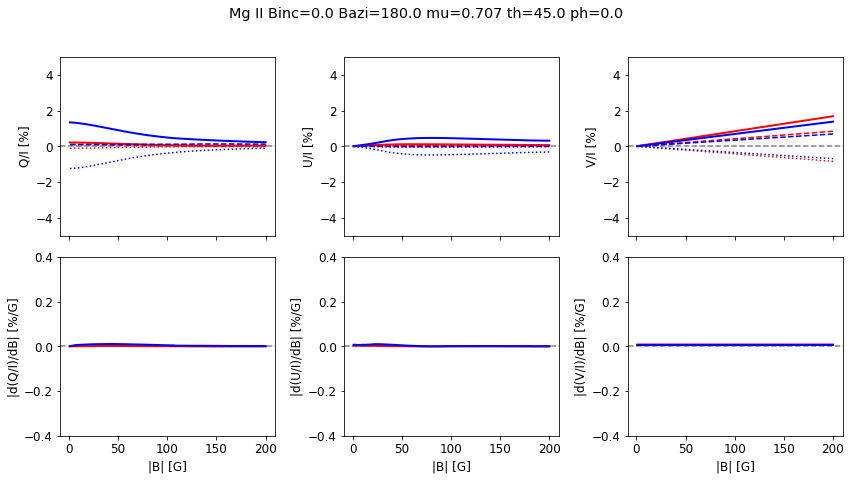

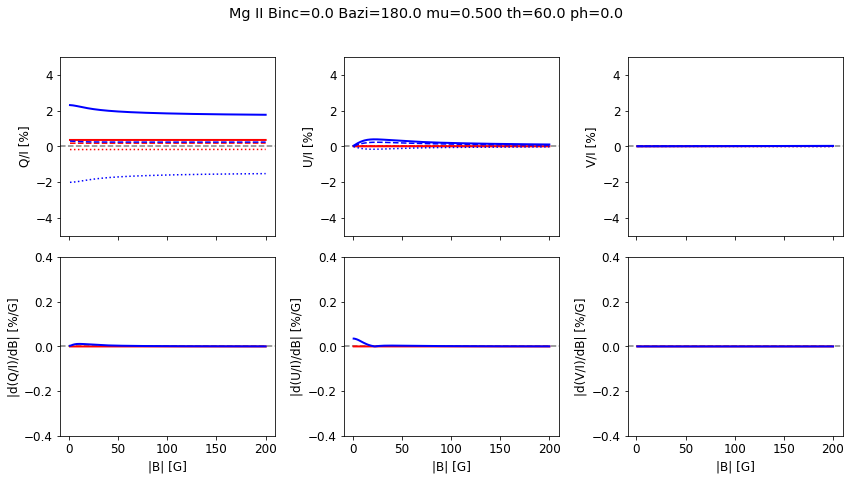

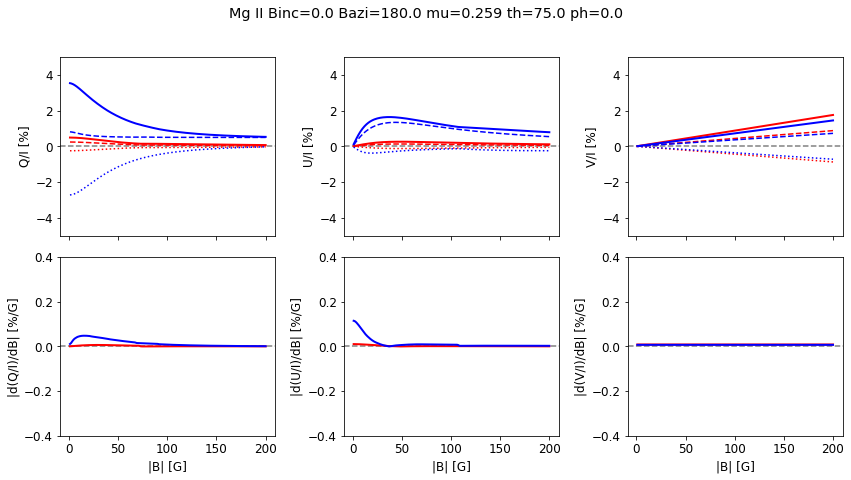

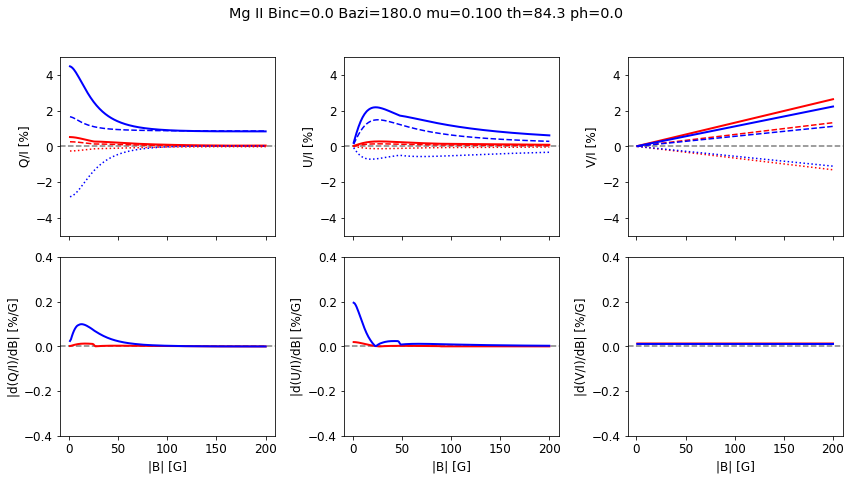

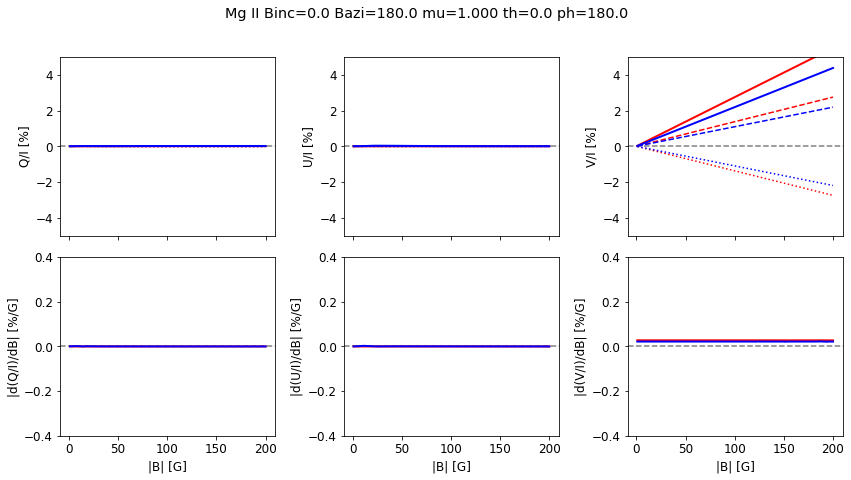

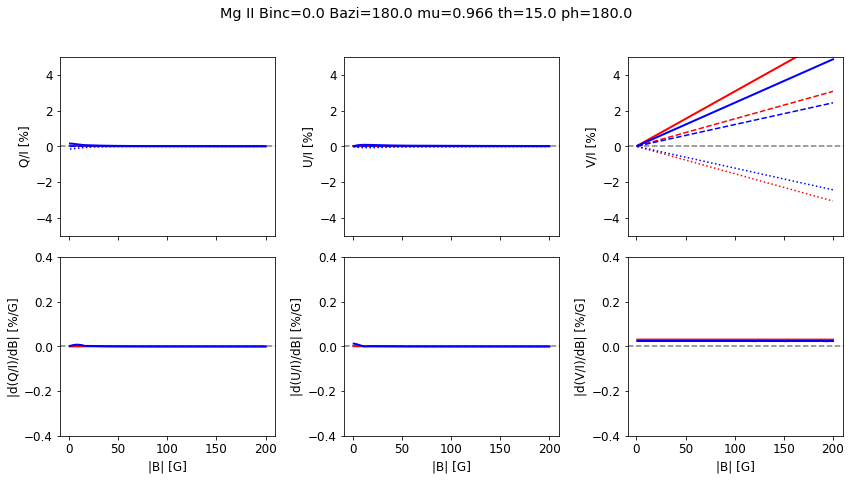

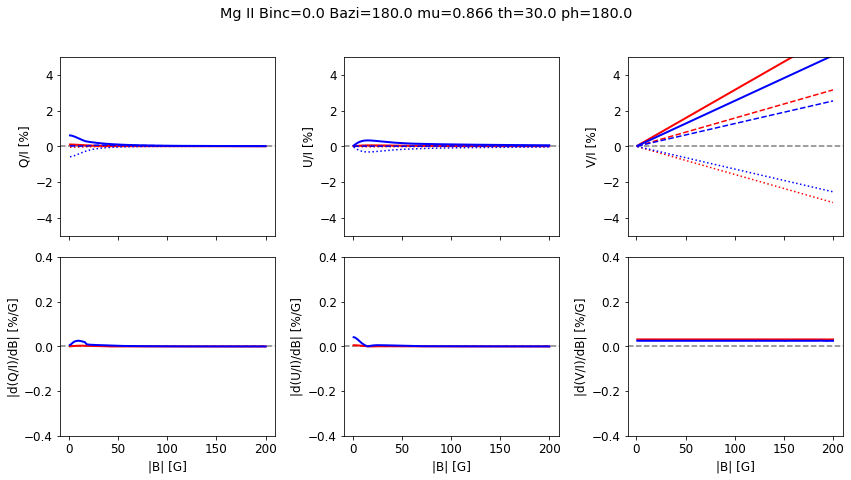

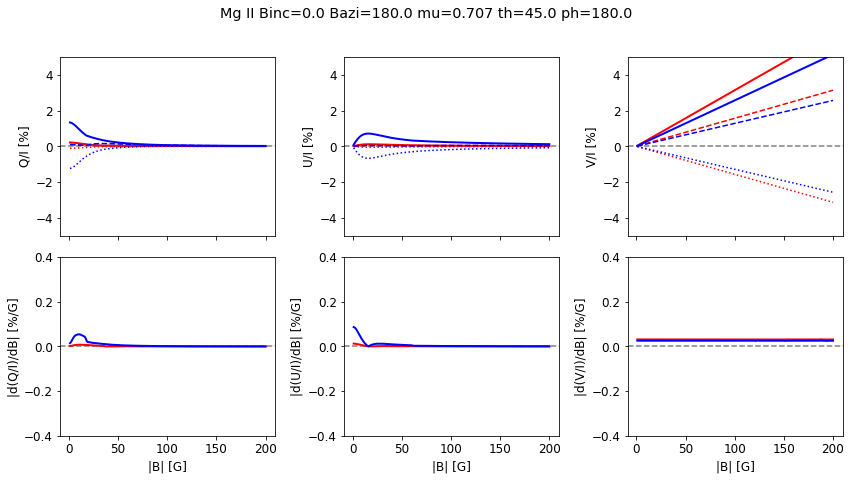

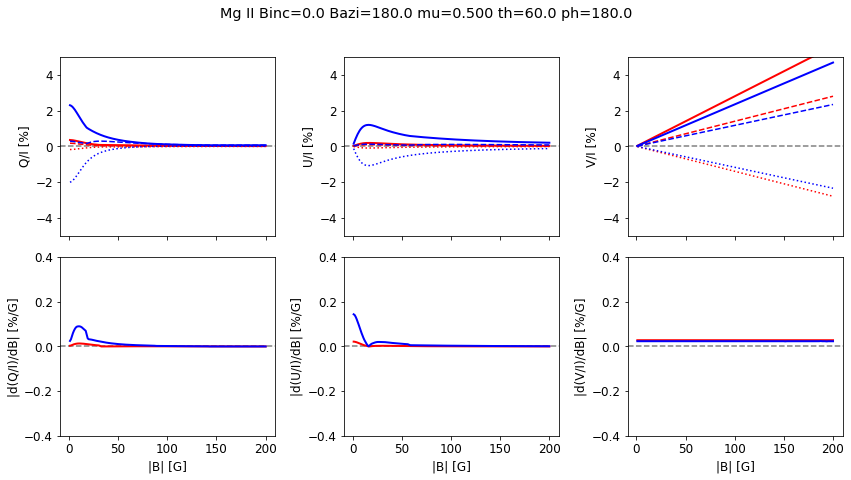

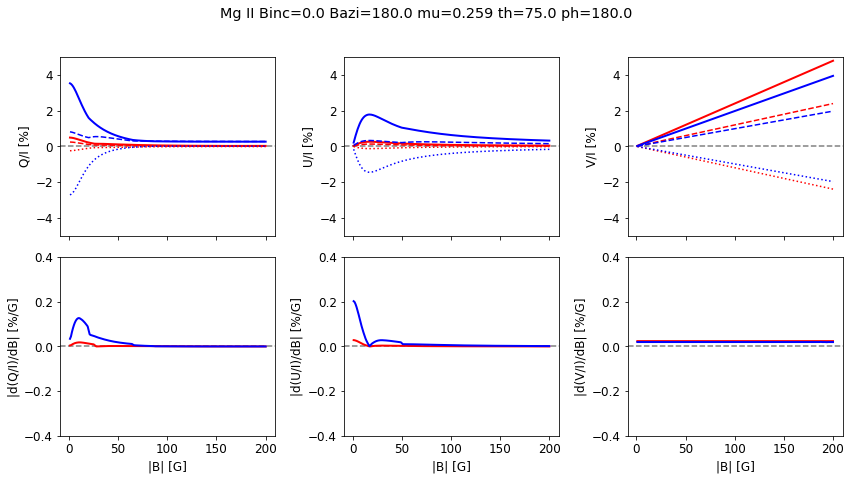

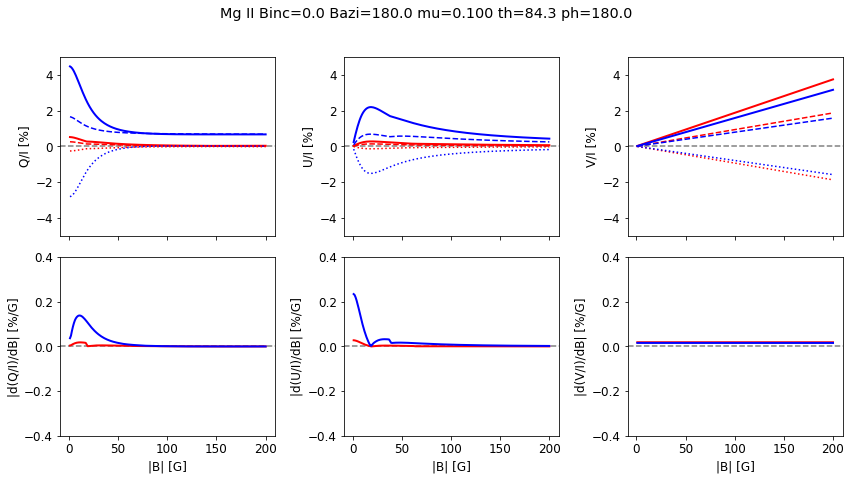

In [32]:
for iph in (1, 13):
    for imu in range(1, 8, 1):
        print(f"plotting response imu={imu} iph={iph}")
        plot_response(imu, iph, abslim=(-5,+5), derivlim=(-0.4,+0.4), save=True)

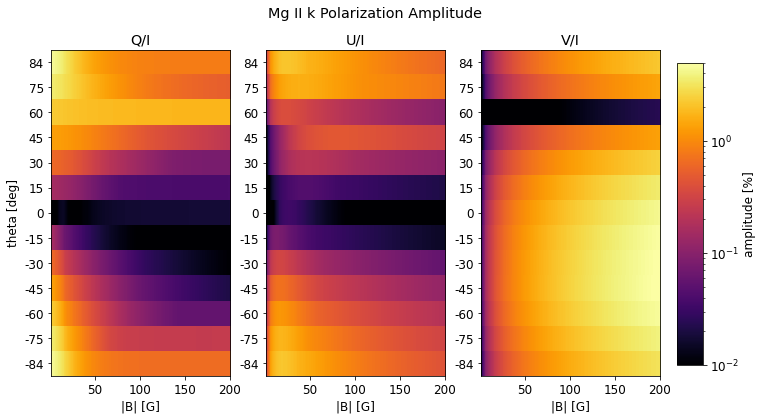

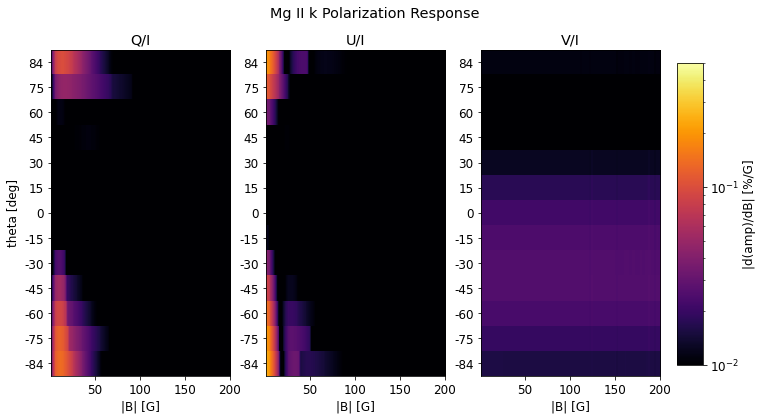

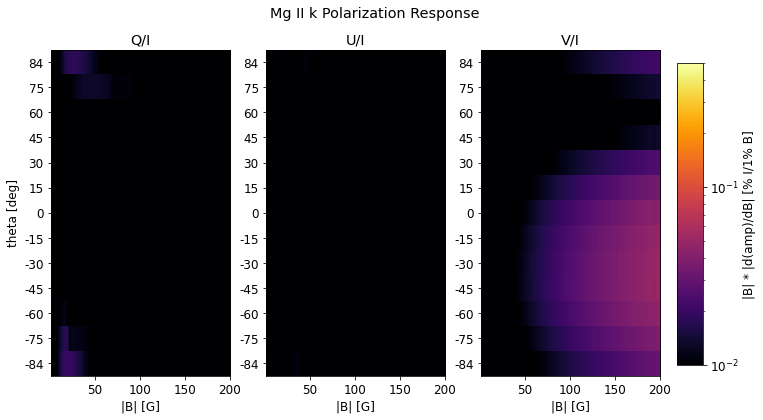

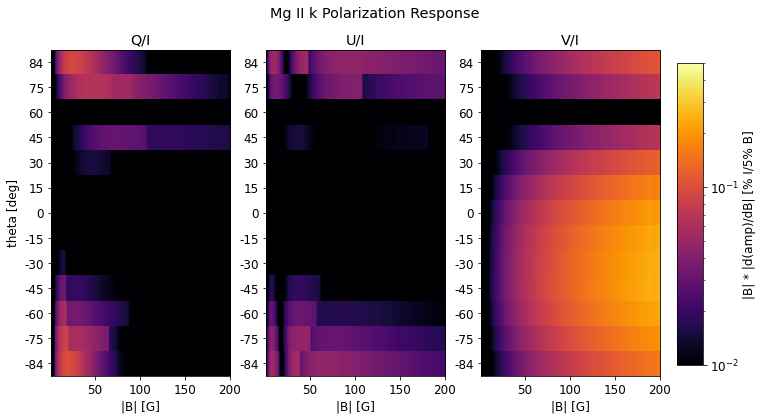

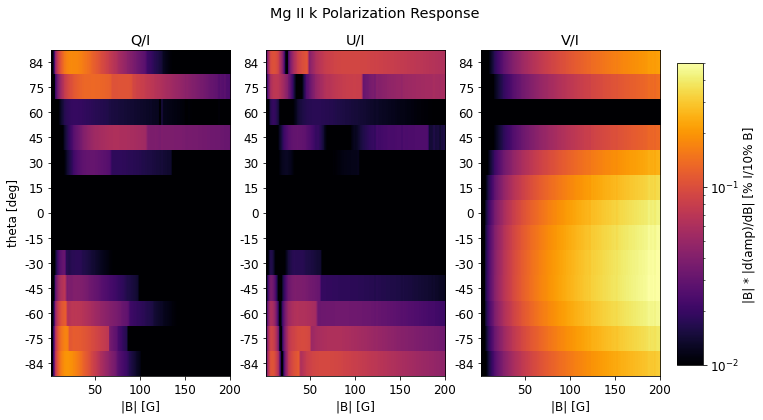

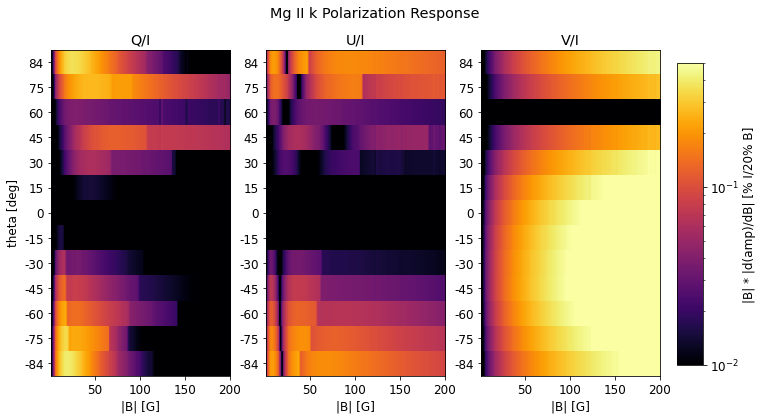

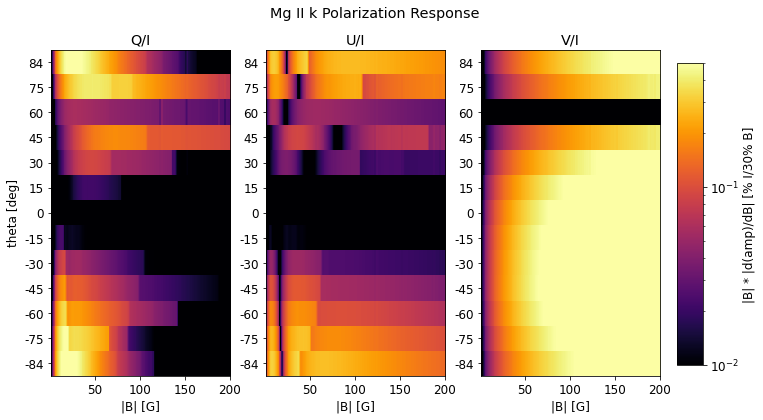

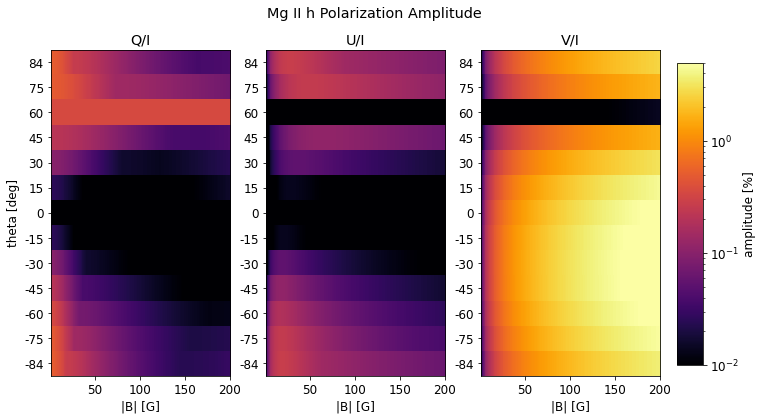

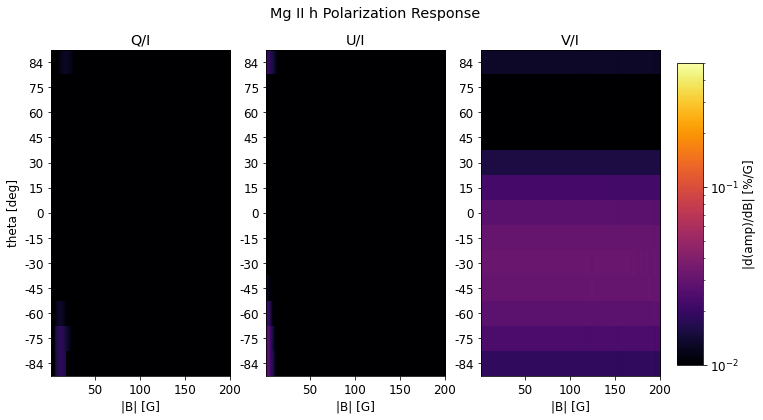

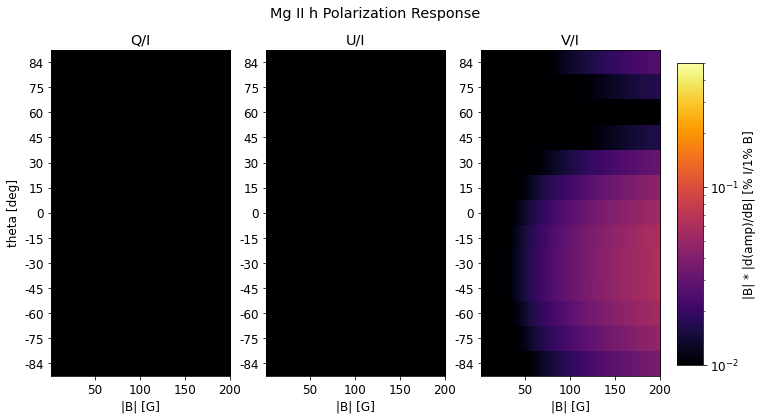

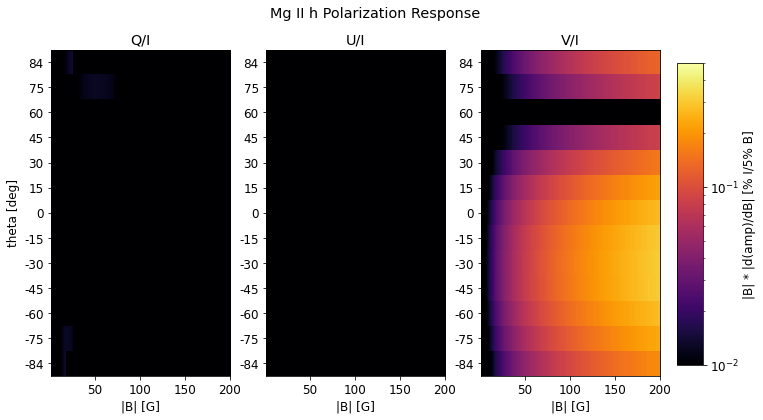

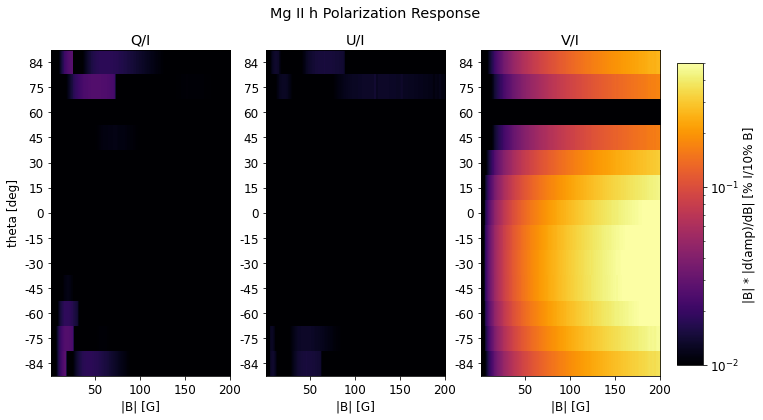

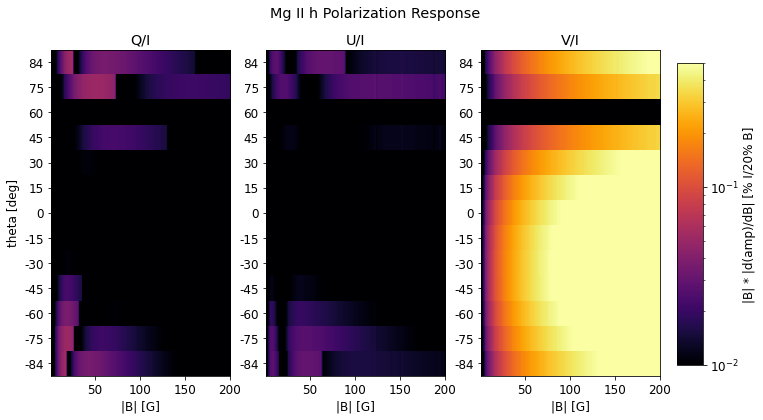

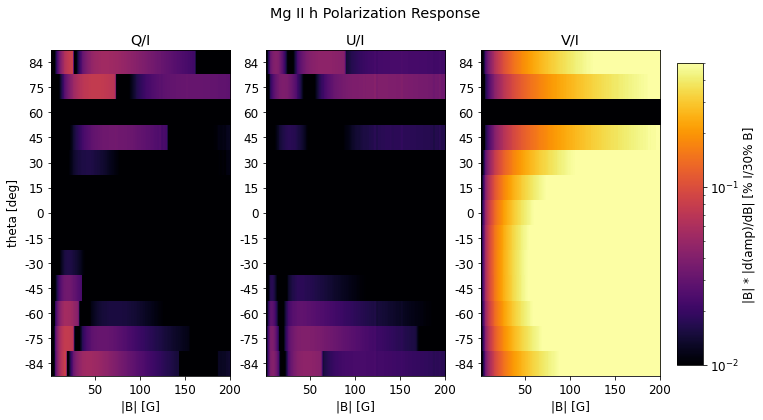

In [34]:
def plot_heatmap(quantity='amp', region='k', vmin=None, vmax=None, dBmult=1, cmap='inferno', save=True):
    if region == 'k':
        ireg = 1
    elif region == 'h':
        ireg = 0
        
    if quantity == 'amp':
        x = amps
        mult = 1
        clabel = 'amplitude [%]'
        savename = f"MgII_heatmap_{region}_amp"
        suptitle = f"Mg II {region} Polarization Amplitude"
    elif quantity == 'dampdB':
        x = dabsampdB
        mult = 1
        clabel = '|d(amp)/dB| [%/G]'
        savename = f"MgII_heatmap_{region}_response"
        suptitle = f"Mg II {region} Polarization Response"
    elif quantity == 'BdampdB':
        x = dabsampdB
        mult = B[selixs][:, 0] / 100. * dBmult # divide by 100 to make percent: (B / (delta B * 100))
        clabel = f"|B| * |d(amp)/dB| [% I/{dBmult}% B]"
        savename = f"MgII_heatmap_{region}_response_rel_{dBmult}pctB"
        suptitle = f"Mg II {region} Polarization Response"

    # heat map of mu angle vs B field
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
    #print(mu_vals)
    #print(th_vals)
    th_labels = [f"{x:0.0f}" for x in th_vals[1:]]
    th_labels_neg = [f"{x*(-1):0.0f}" for x in th_vals[2:]] # omit th=-0 on this axis
    #print(th_labels)
    iSs = (4, 5, 6)
    axs = (ax1, ax2, ax3)
    titles = ('Q/I', 'U/I', 'V/I')
    for i in range(3):
        iS = iSs[i]
        ax = axs[i]
        title = titles[i]
        
        amps_ph0 = mult * x[ireg, 0, :, :, iS] # ph = 0 deg
        amps_ph1 = mult * x[ireg, 12, 1:, :, iS] # ph = 180 deg; omit mu=1.0 (th=0) on this axis
        amps_all = np.append(np.flip(amps_ph1, axis=0), amps_ph0, axis=0)
        if vmin is None:
            vmin = np.min(amps_all)
        if vmax is None:
            vmax = np.max(amps_all)
        im = ax.imshow(amps_all, aspect='auto', interpolation='none', cmap=cmap,
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
                       origin='lower', extent=(1, 200, 0.5, 13.5)) # labels y 1 to 14
        ax.set_yticks(np.arange(1, 13 + 1, 1)) # also 1 to 14; needed for below
        ax.set_yticklabels(np.append(th_labels_neg[::-1], th_labels))
        ax.set_title(title)
        ax.set_xlabel('|B| [G]')
    ax1.set_ylabel('theta [deg]')
    fig.subplots_adjust(right=0.83)
    cax = fig.add_axes([0.85, 0.15, 0.03, 0.70])
    fig.colorbar(im, cax=cax, label=clabel)
    fig.suptitle(suptitle)
    if save:
        fig.savefig(savename + ".png")
    
plot_heatmap(quantity='amp', region='k', vmin=1e-2, vmax=5)
plot_heatmap(quantity='dampdB', region='k', vmin=1e-2, vmax=0.5)
plot_heatmap(quantity='BdampdB', region='k', vmin=1e-2, vmax=0.5, dBmult=1)
plot_heatmap(quantity='BdampdB', region='k', vmin=1e-2, vmax=0.5, dBmult=5)
plot_heatmap(quantity='BdampdB', region='k', vmin=1e-2, vmax=0.5, dBmult=10)
plot_heatmap(quantity='BdampdB', region='k', vmin=1e-2, vmax=0.5, dBmult=20)
plot_heatmap(quantity='BdampdB', region='k', vmin=1e-2, vmax=0.5, dBmult=30)

plot_heatmap(quantity='amp', region='h', vmin=1e-2, vmax=5)
plot_heatmap(quantity='dampdB', region='h', vmin=1e-2, vmax=0.5)
plot_heatmap(quantity='BdampdB', region='h', vmin=1e-2, vmax=0.5, dBmult=1)
plot_heatmap(quantity='BdampdB', region='h', vmin=1e-2, vmax=0.5, dBmult=5)
plot_heatmap(quantity='BdampdB', region='h', vmin=1e-2, vmax=0.5, dBmult=10)
plot_heatmap(quantity='BdampdB', region='h', vmin=1e-2, vmax=0.5, dBmult=20)
plot_heatmap(quantity='BdampdB', region='h', vmin=1e-2, vmax=0.5, dBmult=30)